Thông tin nhóm 2
- Vũ Nguyễn Trung Hiếu - 23122028
- Châu Văn Minh Khoa - 23122035
- Nguyễn Trần Trung Kiên - 23122038
- Phan Ngọc Quân - 23122046

In [ ]:
%pip install nltk
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn

DEPRECATION: Loading egg at c:\users\hp\miniconda3\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..



Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\hp\miniconda3\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\hp\miniconda3\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\hp\miniconda3\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\hp\miniconda3\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\hp\miniconda3\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**1. Tập dữ liệu Enrol-Spam**

Đọc file train.csv và val.csv

In [83]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [84]:
train.head()

,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,0,0,christmas tree farm pictures,NaN,ham,0.038415
1,1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0.696509
2,2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0.587792
3,3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,-0.055438
4,5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,-0.419658


In [85]:
val.head()

,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,23,23,miscellaneous,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,-0.351998
1,24,24,re : purge of old contract _ event _ status,fyi - what do you all think ?\n- - - - - - - -...,ham,0.257704
2,32,32,valero 8018 and 1394,it is my understanding the outages valero incu...,ham,0.091200
3,37,37,01 / 00 natural gas nomination,enron methanol company nominates the following...,ham,-1.745133
4,43,43,re : misc . questions,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,-1.911987


**2. Tiền xử lý dữ liệu**

In [86]:
df = train[['Subject', 'Message', 'Spam/Ham']]
df2 = val[['Subject', 'Message', 'Spam/Ham']]

Xử lý NaN và giá trị lặp

In [87]:
df = df.drop_duplicates()
df = df.fillna("")
df2 = df2.drop_duplicates()
df2 = df2.fillna("")

Tiền xử lý cơ bản:
*   Lower casing
*   Removal of punctuations
*   Removal of stop words
*   Stemming
*   Removal of URLs
*   Removal of HTML tags
*   Removal of email

In [88]:
def clean_text(m):
    m = re.sub(r'^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$','',str(m))
    m = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', ' ', str(m))
    m = re.sub(r'\d+', '', str(m))
    m = re.sub(r'<[^<]+?>', '', str(m))
    m = m.replace(r'[^a-zA-Z]', '')
    m = m.replace('nbsp', '')
    m = m.translate(str.maketrans('', '', punctuation))
    m = m.lower()

    return ' '.join(m.split())


Tiền xử lý Nâng cao bằng Ngram

In [89]:
def preprocess_ngram(df, min_freq=3):
    """
    Tiền xử lý với n-gram

    Args:
        df: DataFrame chứa các cột Subject, Message, Spam/Ham.
        min_freq: Ngưỡng tần suất tối thiểu.

    Returns:
        DataFrame với cột Text và Label (0/1).
    """

    # Khởi tạo đối tượng PorterStemmer
    ps = PorterStemmer()

    # Đếm tần suất từ và bi-gram
    word_freq = defaultdict(int)
    for text in df["Subject"].astype(str) + " " + df["Message"].astype(str):
        text = clean_text(text)  # Sử dụng hàm clean_text để xử lý văn bản
        tokens = re.findall(r'\b\w+\b', text)
        for token in tokens:
            word_freq[token] += 1
        # Bi-gram
        for i in range(len(tokens)-1):
            bigram = f"{tokens[i]}_{tokens[i+1]}"
            word_freq[bigram] += 1

    # Stop words tùy chỉnh
    spam_relevant_words = {'free', 'win', 'won', 'prize', 'offer', 'buy', 'cheap', 'discount'}
    custom_stop_words = set(stopwords.words('english')) - spam_relevant_words

    # Tiến hành tiền xử lý và tạo n-gram
    def process_text(text):
        text = clean_text(text)  # Loại bỏ URL, email, ký tự không phải chữ cái
        tokens = text.split()
        processed = []
        for i, word in enumerate(tokens):
            if word not in custom_stop_words and word_freq[word] >= min_freq:
                processed.append(ps.stem(word) if len(word) > 4 else word)
            if i < len(tokens)-1:
                bigram = f"{word}_{tokens[i+1]}"
                if word_freq.get(bigram, 0) >= min_freq:
                    processed.append(bigram)
        return ' '.join(processed) if processed else 'empty'
    
    df["Text"] = df["Text"].apply(process_text)

    return df

df["Text"] = df["Subject"].astype(str) + " " + df["Message"].astype(str)
df["Label"] = df["Spam/Ham"].apply(lambda x: 1 if x == 'spam' else 0)

df2["Text"] = df2["Subject"].astype(str) + " " + df2["Message"].astype(str)
df2["Label"] = df2["Spam/Ham"].apply(lambda x: 1 if x == 'spam' else 0)

# df["Text"] = df["Text"].apply(clean_text)
# df2["Text"] = df2["Text"].apply(clean_text)
# train_data = df
# val_data = df2

train_data = preprocess_ngram(df)
val_data = preprocess_ngram(df2)

X_train, y_train = train_data['Text'], train_data['Label'].to_numpy()
X_val, y_val = val_data['Text'], val_data['Label'].to_numpy()


In [90]:
X_train

0                 christma christmas_tree tree farm pictur
1        vastar vastar_resources resourc resources_inc ...
2        calpin calpine_daily daili daily_gas gas gas_n...
3        re_issue issu issue_fyi fyi fyi_see see see_no...
4        mcmullen gas gas_for for_jackie jacki sinc sin...
                               ...                        
27277    cure cure_premature prematur premature_ejacula...
27279    error error_hello hello hello_welcome welcom w...
27280    prescript medicin medicines_are are_on on_spec...
27281    the_next next next_generation gener onlin onli...
27282    in_times time times_the the_time time learn le...
Name: Text, Length: 25023, dtype: object

In [91]:
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

**3. Huấn luyện mô hình**

Class NaiveBayes

In [92]:
class NaiveBayesClassifier:
    def __init__(self, alpha=0.3):
        self.class_word_counts = defaultdict(lambda: defaultdict(int))
        self.class_counts = defaultdict(int)
        self.vocab = set()
        self.total_docs = 0
        self.class_totals = defaultdict(int)
        self.alpha = alpha 

    def fit(self, X, y):
        self.total_docs = len(X)
        for text, label in zip(X, y):
            self.class_counts[label] += 1
            tokens = text.split()
            for word in tokens:
                self.class_word_counts[label][word] += 1
                self.vocab.add(word)
                self.class_totals[label] += 1

    def predict(self, X):
        predictions = []
        for text in X:
            tokens = text.split()
            scores = {}
            for label in self.class_counts:
                log_prob = np.log(self.class_counts[label] / self.total_docs)
                for word in tokens:
                    word_freq = self.class_word_counts[label].get(word, 0)
                    word_prob = (word_freq + self.alpha) / (self.class_totals[label] + self.alpha * len(self.vocab))
                    log_prob += np.log(word_prob)
                scores[label] = log_prob
            predictions.append(max(scores, key=scores.get))
        return np.array(predictions)

Hàm đánh giá

In [93]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def recall(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

Huấn luyện mô hình

In [94]:
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

Đánh giá trên tập train và val

In [95]:
train_predict = nb.predict(X_train)
acc = accuracy(y_train, train_predict)
prec = precision(y_train, train_predict)
rec = recall(y_train, train_predict)
f1 = f1_score(y_train, train_predict)
print("Evaluate for train set: \n")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

Evaluate for train set: 

Accuracy : 0.9953
Precision: 0.9963
Recall   : 0.9939
F1-score : 0.9951


In [96]:
val_predict = nb.predict(X_val)
acc_val = accuracy(y_val, val_predict)
prec_val = precision(y_val, val_predict)
rec_val = recall(y_val, val_predict)
f1_val = f1_score(y_val, val_predict)
print("Evaluate for val set: \n")
print(f"Accuracy : {acc_val:.4f}")
print(f"Precision: {prec_val:.4f}")
print(f"Recall   : {rec_val:.4f}")
print(f"F1-score : {f1_val:.4f}")

Evaluate for val set: 

Accuracy : 0.9885
Precision: 0.9907
Recall   : 0.9862
F1-score : 0.9885


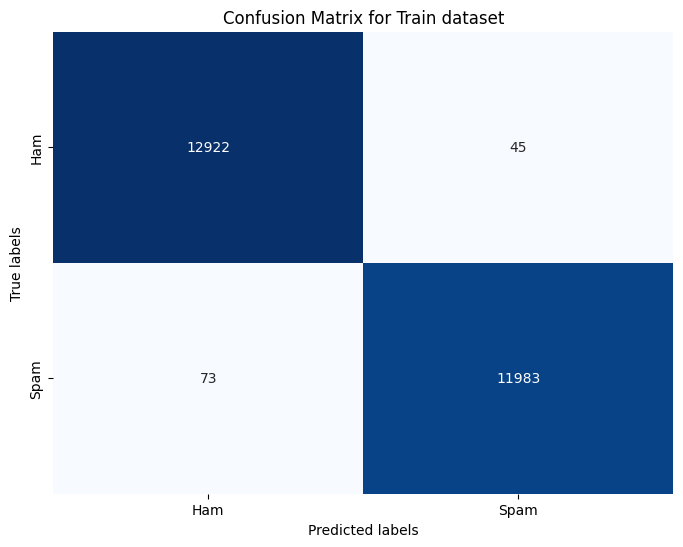

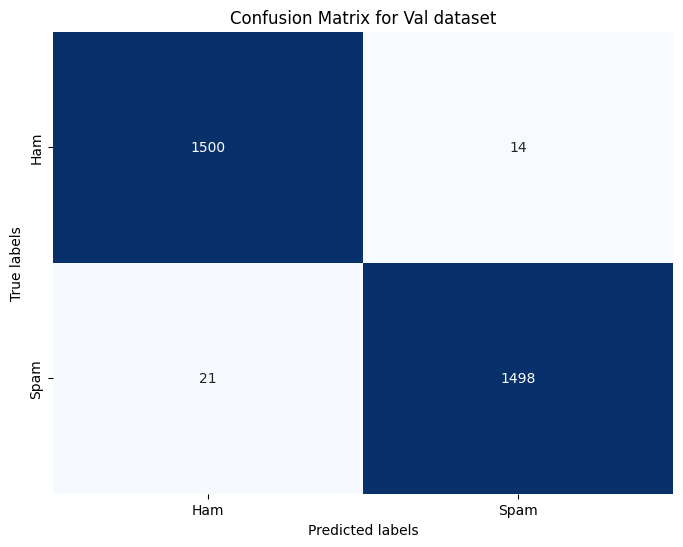

In [97]:
def calculate_confusion_matrix(y_true, y_pred):
    """
    Tính toán Confusion Matrix thủ công.

    Args:
        y_true: Mảng chứa nhãn thực tế.
        y_pred: Mảng chứa nhãn dự đoán từ mô hình.

    Returns:
        confusion_matrix: Mảng 2x2 chứa Confusion Matrix.
    """
    # Khởi tạo các giá trị TP, FP, TN, FN
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Tạo Confusion Matrix
    confusion_matrix = np.array([[TN, FP], [FN, TP]])

    return confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap='Blues'):
    """
    Vẽ confusion matrix từ các nhãn thực tế và nhãn dự đoán.

    Args:
        y_true: Mảng chứa nhãn thực tế.
        y_pred: Mảng chứa nhãn dự đoán từ mô hình.
        classes: Danh sách các lớp (labels).
        title: Tiêu đề của biểu đồ.
        cmap: Bảng màu cho biểu đồ (mặc định là 'Blues').
    """
    # Tính toán Confusion Matrix thủ công
    cm = calculate_confusion_matrix(y_true, y_pred)

    # Vẽ Confusion Matrix với seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes, cbar=False)

    # Thêm tiêu đề và nhãn cho các trục
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    # Hiển thị
    plt.show()

classes = ['Ham', 'Spam']
plot_confusion_matrix(y_train, train_predict, classes, title='Confusion Matrix for Train dataset')
plot_confusion_matrix(y_val, val_predict, classes, title='Confusion Matrix for Val dataset')

**4. Dự đoán thực tế**

Dự đoán mail từ người dùng nhập

In [ ]:
def predict_new_email(model):
    # Nhập tiêu đề và nội dung từ người dùng
    subject = input("Nhập tiêu đề email: ")
    message = input("Nhập nội dung email: ")

    # Gộp và làm sạch văn bản
    text = subject + ' ' + message
    cleaned_text = clean_text(text)

    # Dự đoán
    prediction = model.predict([cleaned_text])  # Đảm bảo truyền vào danh sách một phần tử
    result = 'spam' if prediction[0] == 1 else 'ham'  # Truy cập phần tử đầu tiên của mảng kết quả

    print(f"\nEmail được dự đoán là: {result}")

predict_new_email(nb)

Đánh giá trên file test
Thay file path = đường dẫn file muốn test


Kết quả đánh giá:
Accuracy: 0.9885
Precision: 0.9907
Recall: 0.9862
F1-score: 0.9885


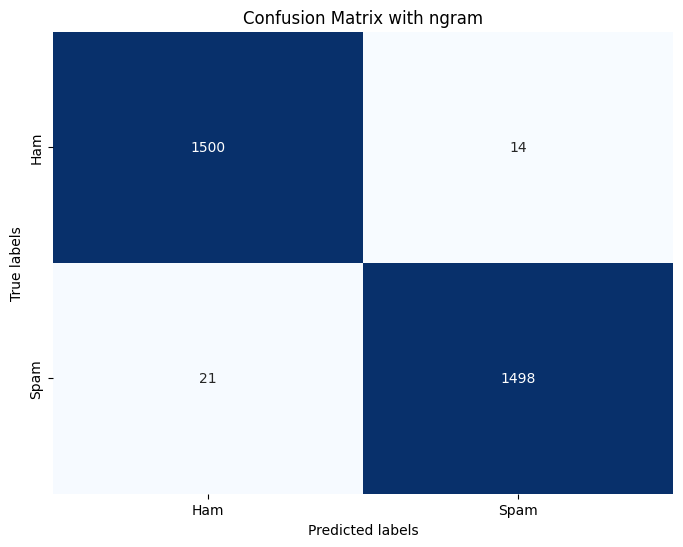

In [ ]:
def evaluate_csv(model, file_path):
    # Đọc file CSV
    try:
        test_df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Lỗi khi đọc file CSV: {e}")
        return

    # Kiểm tra các cột cần thiết
    required_columns = ['Subject', 'Message', 'Spam/Ham']
    if not all(col in test_df.columns for col in required_columns):
        print("File CSV phải chứa các cột: Subject, Message, Spam/Ham")
        return

    # Tiền xử lý dữ liệu
    test_df = test_df[['Subject', 'Message', 'Spam/Ham']]
    test_df = test_df.drop_duplicates()
    test_df = test_df.fillna("")
    test_df["Text"] = test_df["Subject"].astype(str) + " " + test_df["Message"].astype(str)
    test_df["Label"] = test_df["Spam/Ham"].apply(lambda x: 1 if x == 'spam' else 0)
    test_data = preprocess_ngram(test_df)
    X_test, y_test = test_data['Text'], test_data['Label'].to_numpy()

    # Dự đoán trên tập test
    test_pred = model.predict(X_test)

    # Đánh giá mô hình trên toàn bộ dữ liệu
    acc = accuracy(y_test, test_pred)
    pre = precision(y_test, test_pred)
    rec = recall(y_test, test_pred)
    f1 = f1_score(y_test, test_pred)

    # In kết quả
    print("\nKết quả đánh giá:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    classes = ['Ham', 'Spam']
    plot_confusion_matrix(y_test, test_pred, classes, title='Confusion Matrix for Test dataset')

# Ví dụ sử dụng
file_path = "val.csv"
evaluate_csv(nb, file_path)